In [189]:
import pandas as pd
import seaborn as sb
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import sklearn
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [190]:
import pandas as pd
#load Data Source https://www.kaggle.com/datasets/rayhan32/nba-player-status-2003-2023-23k-data?select=NBA+player+status+fro+2003-2023.csv
"""
Column Description
Tm-Team
Age-Age
G-Game
GS-Game started
MP-Minutes played
FG-Field Goals
FGA-Field Goals Attempts
FG%- Field Goal Percentage
3P- 3-Point Field Goal
3PA-3-Point Field Goal Attempts
3P%-3-Point Field Goal Attempts Percentage
2P-2-Point Field Goal
2PA-2-Point Field Goal Attempts
2P%-3-Point Field Goal Attempts Percentage
eFG%-effective field goal percentage (these statistics adjust for the fact that a 3-point field goal is worth one more point than a 2-point goal)
FT-Free Throws
FTA-Free Thrown Attempts
FT%-Free Throwns Attempts Percentage
ORB-Offensive Rebounds
DRB-Defensive Rebounds
TRB-Total Rebounds
AST-Assists
STL-Steals
BLK-Blocks
TOV-Turnovers
PF-Personal Fouls
PTS-Points"""
df = pd.read_csv("https://raw.githubusercontent.com/isaac1987a/Structure_Learning/main/NBA%20player%20status%20fro%202003-2023(1).csv", sep=',', engine='python', 
header=0, encoding='cp1252')
df.head()



,Player,Tm,Age,G,GS,MP,FG,FGA,FG%,3P,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Efe Abogidi,GLI,28.0,4,0,48,6,14,0.429,0,...,0.000,3,10,13,4,0,0,3,10,12
1,Jalen Adaway,AUS,27.0,11,2,234,26,61,0.426,7,...,0.429,7,16,23,11,4,4,3,16,63
2,James Akinjo,WES,31.0,15,5,448,90,195,0.462,28,...,0.800,4,46,50,101,20,0,34,30,232
3,Warith Alatishe,ONT,25.0,14,7,337,48,78,0.615,0,...,0.556,47,57,104,14,16,28,12,47,102
4,Ty-Shon Alexander,GBO,24.0,16,0,257,39,77,0.506,27,...,1.000,2,29,31,23,5,3,17,10,112


In [191]:
#Started by renaming Columns
df = df.rename(columns = {'FG%': 'FGP', '3P%': '3PP', '2P%': '2PP', 'FT%': 'FTP', 'eFG%': 'eFGP'})
print(df.columns)
#Id Nulls, #True is greater than 5% of data missing that item
def FindNulls(df2):
    nulls = []
    for col in df2.columns:
        if df2[col].isna().sum() > 0:
            nulls.append(col + ": " + str(df2[col].isna().sum()) + " " + str(df2[col].isna().sum()/len(df2)))
    for null in nulls:
        print(null)

FindNulls(df)







Index(['Player', 'Tm', 'Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FGP', '3P', '3PA',
       '3PP', '2P', '2PA', '2PP', 'eFGP', 'FT', 'FTA', 'FTP', 'ORB', 'DRB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')
Age: 170 0.07154882154882154
FGP: 66 0.027777777777777776
3PP: 438 0.18434343434343434
2PP: 97 0.040824915824915826
eFGP: 66 0.027777777777777776
FTP: 357 0.15025252525252525


Key point, I selected this dataset at random, and I seem to have chosen poorly.  This dataset has a few very coorlated predictors making for very coorlated models.  

EDA Procedure.  I started with finding all the Nulls.  This had 6 columns of Nulls.  5 of them were percentages of shots made.  After doing a bit of coorlation, I was able to determine that all of those fields matched up with the fact that they had taken 0 of those types of shots.  I then set the empty values to 0.

I then ran a Coorlation Matrix and PairPlot.  There were several features that had almost no coorlations and Age had none.  A few had very strong and linear coorlations.

For the Age Column, for all but the prediction on the age, I just deleted the column as it had no coorlation to any other column from the pairplot.

For choosing the modeling methods, I started by using the Random Forrest to find the most important features.  I paired down the ones that were too much of a match (Who thought that there was a strong coorlation between shots taken and goals), and then did a prediction from the tree and got 97%% accuracy.  After that I used the top predictor to do a Linear regression and got a 78% accuracy.  Afterwards I used reverse stepwise regression and with 8 predictors got a 99.1% accuracy.  Finally I did a KNN which got less than 20% accuracy in most cases.


In [192]:
print("len FTP is NA: " + str(len(df.query('FTP.isna()'))))
print("len FTA is 0: " + str(len(df.query('FTA == 0'))))
print("len FTP is NA and FTA is 0: " + str(len(df.query('FTA == 0 and FTP.isna()'))))


#Ok, so I was able to determine that alot of the empty percentages are from people who shot not shots.  Backfill with 0.
df['FTP'] = df['FTP'].mask(df['FTA'] == 0 & df['FTP'].isna(), other = 0)
df['2PP'] = df['2PP'].mask(df['2PA'] == 0 & df['2PP'].isna(), other = 0)
df['3PP'] = df['3PP'].mask(df['3PA'] == 0 & df['3PP'].isna(), other = 0)
df['FGP'] = df['FGP'].mask(df['FGP'].isna(), other = 0)
df['eFGP'] = df['eFGP'].mask(df['FGA'] == 0 & df['eFGP'].isna(), other = 0)
print(sum(df['3PP'] > 0))
FindNulls(df)
print(df.describe())

len FTP is NA: 357
len FTA is 0: 359
len FTP is NA and FTA is 0: 357
1616
Age: 170 0.07154882154882154
               Age            G           GS           MP           FG  \
count  2206.000000  2376.000000  2376.000000  2376.000000  2376.000000   
mean     24.754306     9.294613     4.725589   228.430135    39.334596   
std       3.079508    11.112549     7.700911   294.038328    55.037905   
min       1.000000     1.000000     0.000000     0.000000     0.000000   
25%      23.000000     2.000000     0.000000    36.000000     5.000000   
50%      24.000000     4.000000     1.000000    90.500000    14.000000   
75%      26.000000    14.000000     6.000000   313.000000    51.000000   
max      39.000000    44.000000    42.000000  1518.000000   321.000000   

               FGA          FGP           3P          3PA          3PP  ...  \
count  2376.000000  2376.000000  2376.000000  2376.000000  2376.000000  ...   
mean     84.282828     0.437917    11.143098    31.768098     0.251354  

A marked improvement.   That leaves age, which can be selectively deleted or replaced depending on the research desired.

Next is a pairplot and a coorplot.


<AxesSubplot: >

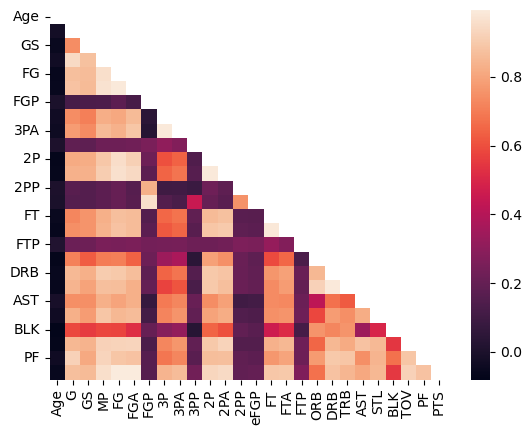

In [193]:
corr = df.corr(numeric_only = True)
mask = np.triu(np.ones_like(corr, dtype=bool))
sb.heatmap(corr, mask = mask)

It is quite supprising that age has no relation to anything else.  The same goes for the shot sink percentages.  I'll be looking at those later.  Most of the other values are fairly coorlated.  


In [194]:
#display(sb.pairplot(df))

Seaborn Pair Plot Results.  This algorhtim takes a while to run and has a known bug on some computers so I have provided a github link to it.

[Picture link](https://github.com/isaac1987a/Structure_Learning/raw/main/Final_Pairplot.png)

It is pretty intresting in that there are some very tightly coorlated variables(Diagionals), some variables with a large variance(Loose but directional), and some that have no coorlation(vertical and horisontal bars).  I did not see anything that would be exponential or would expect to have a curving regression.

My goal is to try to show what factors make the most points as points win games.  To start with, I'm gating to build a random forest to see what correlates to points.


<AxesSubplot: >

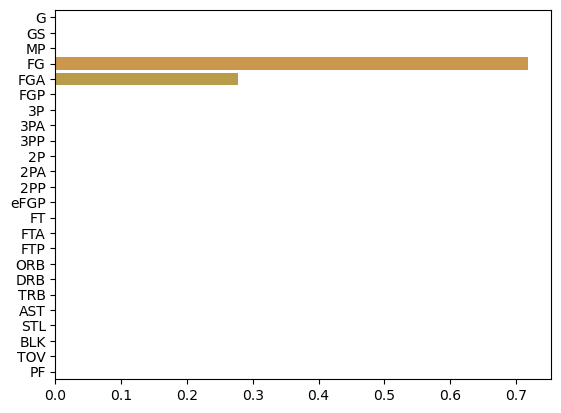

In [195]:
X = df2.drop(['PTS','Player', 'Tm', 'Age'] , axis = 1)
y = df2['PTS']

model = RandomForestRegressor(n_estimators=250, min_samples_split=20).fit(X,y)
sb.barplot(y = model.feature_names_in_ , x = model.feature_importances_)

So according to the Google, "In basketball, a field goal is any shot taken from the court during play."  Color me surprised, taking shots results in goals.  Next, i'm going to redo this while removing field goals.


<AxesSubplot: >

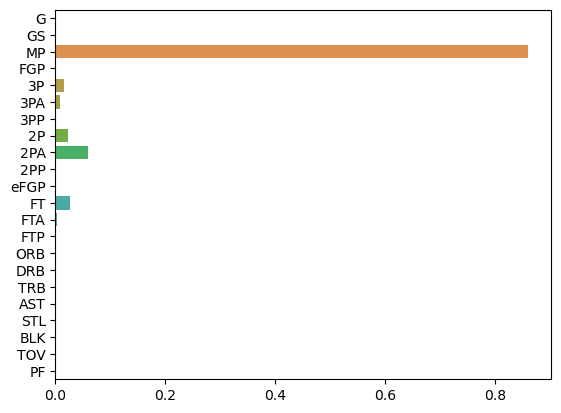

In [196]:
X = X.drop(['FG', 'FGA'], axis = 1)
model = RandomForestRegressor(n_estimators=250, min_samples_split=20).fit(X,y)
sb.barplot(y = model.feature_names_in_ , x = model.feature_importances_)

It is another unsuprising result.  The more time a player has on the field, the more points he scores.  I'm going to remove this column as well.



<AxesSubplot: >

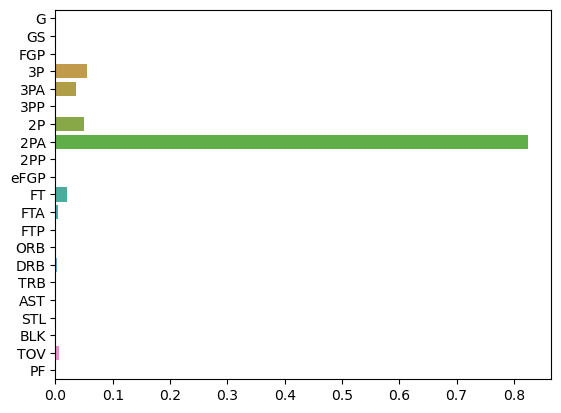

In [197]:
X = X.drop(['MP'], axis = 1)
model = RandomForestRegressor(n_estimators=250, min_samples_split=20).fit(X,y)
sb.barplot(y = model.feature_names_in_ , x = model.feature_importances_)

I'm going to stop with variable paring down here as this chart is just the one above with more detail.  All of the variables about taking shots relate to making points.  The only one that is surprising is turnovers, but that might just be a cross coloration with time.   With this, I'll run this random forest to try and get a useful model. I will use the Sklearn Cross validation model instead of train/test/split.


In [198]:
nfd = sklearn.model_selection.cross_validate(model, X, y = y, cv = 3)
#print(nfd)
print("3 way cross validation test error: " + str(np.mean(nfd['test_score'])))
nfd = None

3 way cross validation test error: 0.9720752444829387


97.1%.  That's a great test error.  This model seems to be very accurate.  I'm not going to print out the tree for this as it doesn't add any thing to the data.


I'm going to stop with variable paring down here as this chart is just the one above with more detail.  All of the variables about taking shots relate to making points.  The only one that is suprising is turnovers, but that might just be a cross coorlation with time.  The last thing I wan to see is what if any variables can be used to predict age.  


<AxesSubplot: >

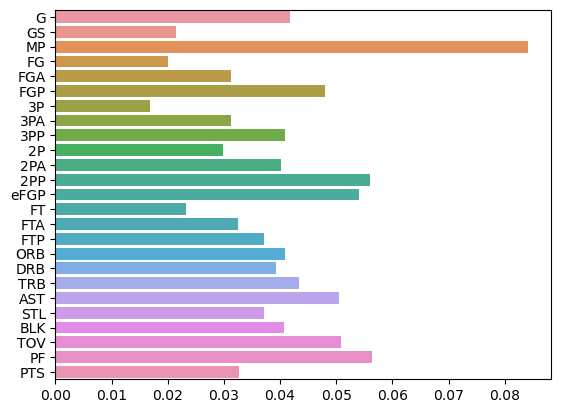

In [199]:
df2 = df[df['Age'].isnull() == False]
X = df2.drop(['Age','Player', 'Tm'] , axis = 1)
y = df2['Age']
model = RandomForestRegressor(n_estimators=250, min_samples_split=20).fit(X,y)
sb.barplot(y = model.feature_names_in_ , x = model.feature_importances_)


It's unsurprising that the only good predictor for age is time on the field.  Teams will likely retain the better players and put them on the court more often, so that is expected.  

Next I decided to try some linear regressors.  I will not be doing any higher order polynomial regression as I didn't see any indication of that during the pairplot.  I will start with just using the 2 point attempts for a single regressor.


In [200]:
X = df2['2PA']
y = df2['PTS']
model = sm.OLS(X,y).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    2PA   R-squared (uncentered):                   0.931
Model:                            OLS   Adj. R-squared (uncentered):              0.931
Method:                 Least Squares   F-statistic:                          2.993e+04
Date:                Thu, 02 Mar 2023   Prob (F-statistic):                        0.00
Time:                        10:46:22   Log-Likelihood:                         -10176.
No. Observations:                2206   AIC:                                  2.035e+04
Df Residuals:                    2205   BIC:                                  2.036e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Ok, and train R2 of .931 and a P of 0.  This looks to be a solid fit.  Lets try cross fold validation.



In [201]:
X = np.array(X).reshape(-1,1)
y = np.array(y).reshape(-1,1)
model = LinearRegression().fit(X,y)
nfd = sklearn.model_selection.cross_validate(model, X, y = y, cv = 3)
print("3 way cross validation test error: " + str(np.mean(nfd['test_score'])))
nfd = None

3 way cross validation test error: 0.7822478032977601


78 Percent coorlation for the singe model prediction.  Thats not bad.  Nexe I chose to do a stepwise regression.  I used the sklearn.feature_selection.RFE model which performs greedy backward stepwise regression to a given value.  I will be excluding field goals again as it would skew the model and not give a good demo of learning.

In [202]:
X = df2.drop(['PTS','Player', 'Tm', 'Age'] , axis = 1)
y = df2['PTS']
model = LinearRegression().fit(X,y)
nfd = RFE(model, n_features_to_select = 5).fit(X,y)
z = [print("Name: " + str(feature) + " Ranking: " + str(ranking)) for feature, ranking in zip(nfd.feature_names_in_, nfd.ranking_)]
features = pd.DataFrame({"Name": list(nfd.feature_names_in_),"Ranking": list(nfd.ranking_)})
features = (features.sort_values('Ranking'))
X = df2[features[0:5]['Name']]
model = LinearRegression().fit(X,y)
nfd = sklearn.model_selection.cross_validate(model, X, y = y, cv = 3)

print("3 way cross validation test error: " + str(np.mean(nfd['test_score'])))
nfd = None
train = []
test = []

for n in range(1,20):
    df2 = df[df['Age'].isnull() == False]
    X = df2.drop(['PTS','Player', 'Tm'] , axis = 1)
    y = df2['PTS']
    model = LinearRegression().fit(X,y)
    nfd = RFE(model, n_features_to_select = n).fit(X,y)
    features = pd.DataFrame({"Name": list(nfd.feature_names_in_),"Ranking": list(nfd.ranking_)})
    features = (features.sort_values('Ranking'))
    X = df2[features[0:n]['Name']]
    model = LinearRegression().fit(X,y)
    nfd = sklearn.model_selection.cross_validate(model, X, y = y, cv = 3, return_train_score = True)
    print("3 way cross validation test error for top " + str(n) + " predictors  is " + str(np.mean(nfd['test_score'])))


Name: G Ranking: 5
Name: GS Ranking: 12
Name: MP Ranking: 20
Name: FG Ranking: 14
Name: FGA Ranking: 9
Name: FGP Ranking: 1
Name: 3P Ranking: 2
Name: 3PA Ranking: 8
Name: 3PP Ranking: 1
Name: 2P Ranking: 3
Name: 2PA Ranking: 6
Name: 2PP Ranking: 1
Name: eFGP Ranking: 1
Name: FT Ranking: 4
Name: FTA Ranking: 19
Name: FTP Ranking: 1
Name: ORB Ranking: 11
Name: DRB Ranking: 10
Name: TRB Ranking: 7
Name: AST Ranking: 16
Name: STL Ranking: 13
Name: BLK Ranking: 17
Name: TOV Ranking: 15
Name: PF Ranking: 18
3 way cross validation test error: -3.217432678990708
3 way cross validation test error for top 1 predictors  is -3.320587874260514
3 way cross validation test error for top 2 predictors  is -3.096894535612084
3 way cross validation test error for top 3 predictors  is -2.7218090106543094
3 way cross validation test error for top 4 predictors  is -2.800768193505514
3 way cross validation test error for top 5 predictors  is -3.2174326789907077
3 way cross validation test error for top 6 pre

This shows that a model with the top 5 predictors of (3 point %, #3pt shots sunk, # of 2pt shots sunk, FT, and # of games played.  I then looked at what happens with 1-20 variables.  The model does exceptionally well using 7 predictors but the test error goes wonky sometimes.  Finally, due to the garbage score numbers, I am forgoing the graph of the scores.

Finally, just to finish this off, I chose to test a KNN algorithim.  This algorithim suffers greatly from the curse of dimmentionality and I'm giving it 20 varibles.  I will iterate through using 3 fold cross validation.

Please just scroll through the errors, they are just nusance, but the model works normally.

C:\Users\isaac\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\isaac\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\isaac\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\isaac\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\isaac\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\isaac\anaconda3\lib\s

Text(0.5, 1.0, 'Test Error')

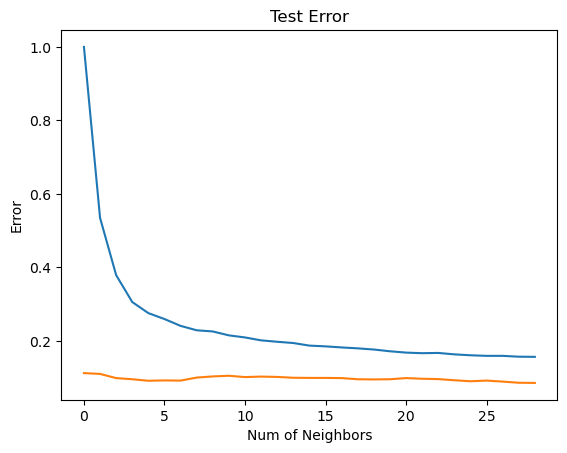

In [203]:
X = df2.drop(['PTS','Player', 'Tm', 'Age'] , axis = 1)
y = df2['PTS']
train = []
test = []
for n in range(1,30):
    model = KNN(n_neighbors = n)
    nfd = sklearn.model_selection.cross_validate(model, X, y = y, cv = 3, return_train_score = True)
    #print(str(n) + " Nearest Nieghbors gives " + str(np.mean(nfd['test_score'])) + " test error")
    train.append(np.mean(nfd['train_score']))
    test.append(np.mean(nfd['test_score']))

plot = plt.plot(train)
plt.xlabel("Num of Neighbors")
plt.ylabel("Error")
plt.title("Train Error")
plot2 =  plt.plot(test)
plt.xlabel("Num of Neighbors")
plt.ylabel("Error")
plt.title("Test Error")

As you can see with the multitude of future problem warnings, the KNN algorithim did poorly in test errors, but did steadily badly.  There are 2 things that can be done to improve the performance of KNN. Scaling and dimmension reduction.  I reduce the dimmensions to 5.

C:\Users\isaac\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\isaac\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\isaac\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\isaac\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\isaac\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\isaac\anaconda3\lib\s

Text(0.5, 1.0, 'Test Error')

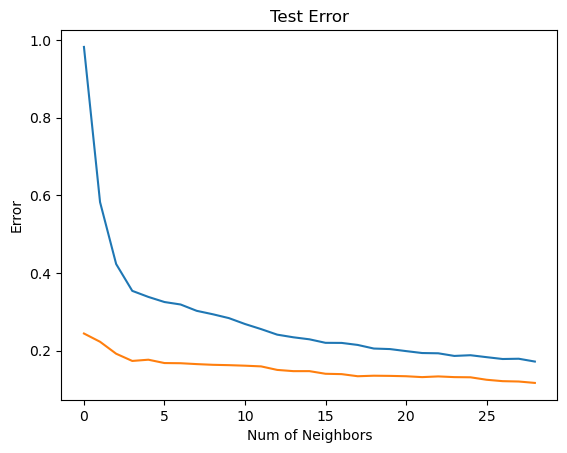

In [204]:
train = []
test = []
X = df2[['3PP', '3P', '2P', 'FT', 'G']]
y = df2['PTS']
for n in range(1,30):
    model = KNN(n_neighbors = n)
    nfd = sklearn.model_selection.cross_validate(model, X, y = y, cv = 3, return_train_score = True)
    #print(str(n) + " Nearest Nieghbors gives " + str(np.mean(nfd['test_score'], keepdims = False)) + " test error")
    train.append(np.mean(nfd['train_score']))
    test.append(np.mean(nfd['test_score']))

plot = plt.plot(train)
plt.xlabel("Num of Neighbors")
plt.ylabel("Error")
plt.title("Train Error")
plot2 =  plt.plot(test)
plt.xlabel("Num of Neighbors")
plt.ylabel("Error")
plt.title("Test Error")

This is an improvement in performance of the KNN Model. Cherry picking 5 models does help a bit, but the test error is still fairly abysmal with over 5 neighbors..

In Conclusion, this parts of this data are very coorlated and linear.  I chose the data set at random and just ran with it.  I started with cleaning the data.  The data had 6 fields with NaN's in them.  I was able to coorlate 5 of the fields with another field and set the NaN's to 0.  Then I ended up throwing out the values from the remaining field that had NaN's in them.  I probalby should have just thrown out that column instead.  

The Random Forrest model shows a 97% accuracy using the key predictors.  Single SVM shows 78% when using the tree to pick the best variable. Using a backward stepwise regression, I got 99.1% accuracy with 8 features.  More features after that didn't help.  And K Nearerst Nieghbors didnt get over 25% even when scaling and reducing the number of predictors.  Overall, this data had a few very strongly related predictors.  Thats what I get for randomly choosing a dataset and just running with it.